In [1]:
import torch
import torch.nn as nn

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

$$
\begin{aligned}
\text{MultiHead}(Q, K, V) &= \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O \\
\text{where head}_i &= \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
\end{aligned}
$$

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        ### Multi Head Attention
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = self.values(values) 
        keys = self.keys(keys) 
        queries = self.queries(query)

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        # Attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Softmax
        attention = torch.softmax(energy / (self.head_dim ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)

        return out

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        # Multi Head Attention
        attention = self.attention(value, key, query, mask)

        # Add + Norm
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Encoder

## Positional Encoding -> Multi Head Attention -> Add & Norm

In [5]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
 
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

# Dncoder

## Positional Encoding -> Masked Multi Head Attention -> Multi Head Attention -> Add & Norm

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x)) # Add(Skip Connection) + Norm -> Dropout
        out = self.transformer_block(value, key, query, src_mask) 
        return out

In [7]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        out = self.fc_out(x)

        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cpu",
        max_length=100,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    ### Encoder
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    ### Decoder
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

In [9]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(
        device
    )
    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
        device
    )
    out = model(x, trg[:, :-1])
    print(out.shape)

cpu
torch.Size([2, 7, 10])


🚀 하이퍼파라미터 튜닝 시작...
Testing: LR=0.001, Layers=2, Heads=4, Embed=128
[Epoch 10/10] Loss: 4.2186
Testing: LR=0.001, Layers=2, Heads=4, Embed=256
[Epoch 10/10] Loss: 3.3521
Testing: LR=0.001, Layers=2, Heads=8, Embed=128
[Epoch 10/10] Loss: 4.2682
Testing: LR=0.001, Layers=2, Heads=8, Embed=256
[Epoch 10/10] Loss: 3.3190
Testing: LR=0.001, Layers=4, Heads=4, Embed=128
[Epoch 10/10] Loss: 4.3406
Testing: LR=0.001, Layers=4, Heads=4, Embed=256
[Epoch 10/10] Loss: 3.6525
Testing: LR=0.001, Layers=4, Heads=8, Embed=128
[Epoch 10/10] Loss: 4.3210
Testing: LR=0.001, Layers=4, Heads=8, Embed=256
[Epoch 10/10] Loss: 3.7646
Testing: LR=0.0005, Layers=2, Heads=4, Embed=128
[Epoch 10/10] Loss: 4.4247
Testing: LR=0.0005, Layers=2, Heads=4, Embed=256
[Epoch 10/10] Loss: 4.0381
Testing: LR=0.0005, Layers=2, Heads=8, Embed=128
[Epoch 10/10] Loss: 4.4796
Testing: LR=0.0005, Layers=2, Heads=8, Embed=256
[Epoch 10/10] Loss: 4.0947
Testing: LR=0.0005, Layers=4, Heads=4, Embed=128
[Epoch 10/10] Loss: 4.5144
T

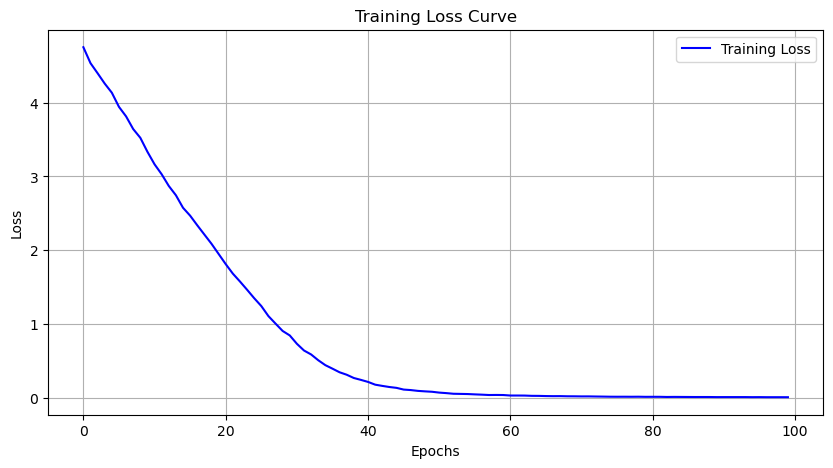

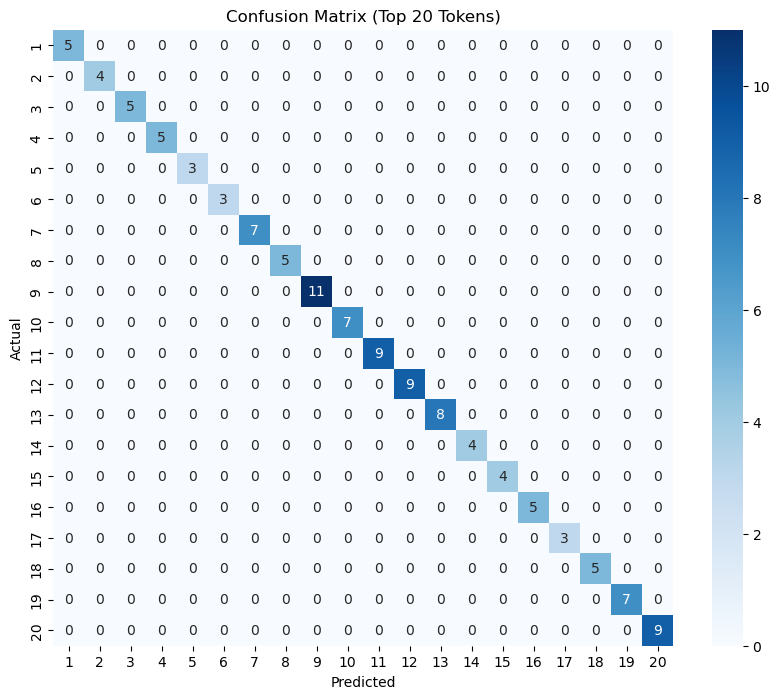

In [10]:
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# ==========================================
# 1. 간단한 학습 및 평가 함수 (Training Loop)
# ==========================================
def train_model(model, src_data, trg_data, epochs, lr, device):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0) # pad_idx=0 무시

    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Transformer 입력: (src, trg)
        # trg의 마지막 토큰을 제외한 것을 입력으로 사용 (Teacher Forcing)
        output = model(src_data, trg_data[:, :-1])
        
        # 출력: (N, trg_len, trg_vocab_size) -> (N * trg_len, trg_vocab_size)
        # 정답: (N, trg_len) -> trg의 첫 토큰(<SOS>)을 제외한 것을 정답으로 사용
        output = output.reshape(-1, output.shape[2])
        target = trg_data[:, 1:].reshape(-1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] Loss: {loss.item():.4f}")

    return loss_history

# ==========================================
# 2. 하이퍼파라미터 튜닝 (Hyperparameter Tuning)
# ==========================================
def hyperparameter_tuning(src_data, trg_data, device):
    # 실험할 파라미터 그리드 (원하는 대로 수정 가능)
    # 랩미팅용이라 간단하게 설정했습니다.
    param_grid = {
        'learning_rate': [0.001, 0.0005],
        'num_layers': [2, 4],
        'heads': [4, 8],
        'embed_size': [128, 256] # head로 나누어 떨어지는 값이어야 함
    }
    
    best_loss = float('inf')
    best_params = {}
    results = []

    print("🚀 하이퍼파라미터 튜닝 시작...")
    
    # Grid Search (단순 반복문)
    for lr in param_grid['learning_rate']:
        for n_layers in param_grid['num_layers']:
            for h in param_grid['heads']:
                for emb in param_grid['embed_size']:
                    # Head 나누기 조건 체크 (assert 방지)
                    if emb % h != 0: continue

                    print(f"Testing: LR={lr}, Layers={n_layers}, Heads={h}, Embed={emb}")
                    
                    # 모델 초기화
                    model = Transformer(
                        src_vocab_size=100, trg_vocab_size=100,
                        src_pad_idx=0, trg_pad_idx=0,
                        embed_size=emb, num_layers=n_layers, 
                        forward_expansion=2, heads=h, dropout=0.1, 
                        device=device, max_length=50
                    ).to(device)
                    
                    # 짧게 학습 (튜닝용이라 10 에포크만)
                    losses = train_model(model, src_data, trg_data, epochs=10, lr=lr, device=device)
                    final_loss = losses[-1]
                    
                    if final_loss < best_loss:
                        best_loss = final_loss
                        best_params = {'lr': lr, 'num_layers': n_layers, 'heads': h, 'embed_size': emb}
    
    print("-" * 50)
    print(f"🏆 Best Params: {best_params} (Loss: {best_loss:.4f})")
    print("-" * 50)
    return best_params

# ==========================================
# 3. 시각화 함수들 (Loss Plot & Confusion Matrix)
# ==========================================
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss', color='blue')
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model, src_data, trg_data):
    model.eval()
    with torch.no_grad():
        output = model(src_data, trg_data[:, :-1])
        
        # 예측값 (가장 확률 높은 단어 인덱스)
        predictions = torch.argmax(output, dim=2).reshape(-1).cpu().numpy()
        targets = trg_data[:, 1:].reshape(-1).cpu().numpy()
        
        # 패딩(0)은 제외하고 보기 (시각화 깔끔하게)
        mask = targets != 0
        filtered_preds = predictions[mask]
        filtered_targets = targets[mask]

        # 혼동 행렬 생성 (상위 10개 클래스만 샘플링하여 시각화)
        # 실제로는 vocab 전체를 하면 너무 커서 안 보임
        labels = np.unique(filtered_targets)
        if len(labels) > 20: 
            labels = labels[:20] # 상위 20개만 자름
            
        cm = confusion_matrix(filtered_targets, filtered_preds, labels=labels)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix (Top 20 Tokens)')
        plt.show()

# ==========================================
# 4. 실행 (Main)
# ==========================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # --- [데이터 생성] 임의의 데이터 (실제 데이터 대신 사용) ---
    BATCH_SIZE = 32
    SEQ_LEN = 20
    SRC_VOCAB = 100
    TRG_VOCAB = 100
    
    # 랜덤 데이터 생성 (0은 패딩으로 가정)
    src_data = torch.randint(1, SRC_VOCAB, (BATCH_SIZE, SEQ_LEN)).to(device)
    trg_data = torch.randint(1, TRG_VOCAB, (BATCH_SIZE, SEQ_LEN)).to(device)
    
    # 1. 하이퍼파라미터 튜닝 실행
    best_params = hyperparameter_tuning(src_data, trg_data, device)
    
    # 2. 최적의 파라미터로 본격 학습 (Epoch 늘려서)
    print("🔥 최적의 모델로 다시 학습 중...")
    final_model = Transformer(
        src_vocab_size=SRC_VOCAB, trg_vocab_size=TRG_VOCAB,
        src_pad_idx=0, trg_pad_idx=0,
        embed_size=best_params['embed_size'], 
        num_layers=best_params['num_layers'], 
        forward_expansion=2, 
        heads=best_params['heads'], 
        dropout=0.1, 
        device=device, 
        max_length=100
    ).to(device)
    
    final_losses = train_model(final_model, src_data, trg_data, epochs=100, lr=best_params['lr'], device=device)
    
    # 3. 결과 시각화
    print("📊 결과 그래프 그리는 중...")
    plot_loss(final_losses)
    plot_confusion_matrix(final_model, src_data, trg_data)